# Local and Central DP with Fed-BioMed: MONAI 2d image registration

## Introduction

This tutorial shows how to deploy in Fed-BioMed the 2d image registration example provided in the project MONAI (https://monai.io/), trained with Differential Privacy (DP). We are going to compare results of:
* non private training
* train with Local Differential Privacy (LDP)
* train with Central Differential Privacy (CDP)

In order to enforce differential privacy during training (both local and central) we will rely on the Opcaus library (https://opacus.ai/). 

## Image Registration

Image registration is the process of transforming and recalibrating different images into one coordinate system. It makes possible to compare several images captured with the same modality.

In this tutorial, we are using a UNet-like registration network ( https://arxiv.org/abs/1711.01666 ).
Goal of the notebook is to train a model given moving images and fixed images (recalibrated images). 

## Start the network
Before running this notebook, start the network with `./scripts/fedbiomed_run network`

## Creating MedNIST nodes

MedNIST provides an artificial 2d classification dataset created by gathering different medical imaging datasets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

To proceed with the tutorial, we created an iid partitioning of the MedNIST dataset between 3 clients. Each client has 3000 image samples for each class. The training partitions are availables at the following link:

https://drive.google.com/file/d/1vLIcBdtdAhh6K-vrgCFy_0Y55dxOWZwf/view

The dataset owned by each client has structure:


└── client_*/

    ├── AbdomenCT/
    
    └── BreastMRI/
    
    └── CXR/
    
    └── ChestCT/
    
    └── Hand/
    
    └── HeadCT/   

To create the federated dataset, we follow the standard procedure for node creation/population of Fed-BioMed. 
After activating the fedbiomed network with the commands

`source ./scripts/fedbiomed_environment network`

and 

`./scripts/fedbiomed_run network`

we create a first node by using the commands

`source ./scripts/fedbiomed_environment node`

`./scripts/fedbiomed_run node start`

We then poulate the node with the data of first client:

`./scripts/fedbiomed_run node add`

We select option 3 (images) to add MedNIST partition of client 1, by just picking the folder of client 1. 
Assign tag `mednist` to the data when asked.

We can further check that the data has been added by executing `./scripts/fedbiomed_run node list`

Following the same procedure, we create the other two nodes with the datasets of client 2 and client 3 respectively.


## Running Fed-BioMed Researcher

We are now ready to start the reseracher enviroment with the command `source ./scripts/fedbiomed_environment researcher`, and open the Jupyter notebook. 

We can first quesry the network for the mednist dataset. In this case, the nodes are sharing the respective partitions unsing the same tag `mednist`:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2022-07-05 10:38:29,558 fedbiomed INFO - Component environment:
2022-07-05 10:38:29,559 fedbiomed INFO - type = ComponentType.RESEARCHER
2022-07-05 10:38:33,557 fedbiomed INFO - Messaging researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3 successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x139619a90>
2022-07-05 10:38:33,624 fedbiomed INFO - Listing available datasets in all nodes... 
2022-07-05 10:38:57,543 fedbiomed INFO - 
 Node: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 | Number of Datasets: 1 
+---------+-------------+-------------+---------------+--------------------+
| name    | data_type   | tags        | description   | shape              |
+=========+=============+=============+===============+====================+
| mednist | images      | ['mednist'] | bla           | [76954, 3, 64, 64] |
+---------+-------------+-------------+---------------+--------------------+

2022-07-05 10:38:57,544 fedbiomed INFO - 
 Node: node_849228e

{'node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'bla',
   'shape': [76954, 3, 64, 64]}],
 'node_849228e1-b326-4db7-a087-71d9bc634b4f': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'bla bla',
   'shape': [16954, 3, 64, 64]}]}

## Create an experiment to train a model on the data found

The code for network and data loader of the MONAI tutorial can now be deployed in Fed-BioMed.
We first import the necessary modules from `fedbiomed` and `monai` libraries:

In [3]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

We can now define the training plan. Note that we use the standard `TorchTrainingPlan` natively provided in Fed-BioMed. We reuse the `MedNISTDataset` data loader defined in the original MONAI tutorial, which is returned by the method `training_data`, which also implements the data parsing from the nodes `dataset_path`. We should also properly define the `training_routine`, following the MONAI tutorial. According to the MONAI tutorial, the model is the `GlobalNet` and the loss is `MSELoss`.

In [4]:
import os
import numpy as np
import torch
from torch.nn import MSELoss
import torch.nn as nn
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.logger import logger
from fedbiomed.common.data import DataManager
from torchvision import datasets, transforms
from typing import Union, List

#from torch.utils.data import Dataset, DataLoader
import monai
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset


# Here we define the model to be used. 
class MyTrainingPlan(TorchTrainingPlan):
    def __init__(self, model_args: dict = {}):
        super(MyTrainingPlan, self).__init__(model_args)
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        # In this case, we need the torch DataLoader classes
        # Since we will train on MNIST, we need datasets and transform from torchvision
        deps = ["import numpy as np",
                "import monai",
                "from torch.nn import MSELoss",
                "from monai.utils import set_determinism, first",
                "from monai.transforms import (EnsureChannelFirstD,Compose,LoadImageD,RandRotateD,RandZoomD,ScaleIntensityRanged,EnsureTypeD,)",
                "from monai.data import DataLoader, Dataset, CacheDataset",
                "from monai.networks.nets import GlobalNet",
                "from monai.config import USE_COMPILED",
                "from monai.networks.blocks import Warp",
                "from monai.apps import MedNISTDataset",
                "from opacus.validators import ModuleValidator"]
        self.add_dependency(deps)
        
        self.model = GlobalNet(
            image_size=(64, 64),
            spatial_dims=2,
            in_channels=2,  # moving and fixed
            num_channel_initial=16,
            depth=3)
        self.image_loss = MSELoss()
        
        if USE_COMPILED:
            self.warp_layer = Warp(3, "border")
        else:
            self.warp_layer = Warp("bilinear", "border")
            
    def make_optimizer(self,lr):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def training_data(self, batch_size = 20):
        # Custom torch Dataloader for MedNIST data
        data_path = self.dataset_path
        # The following line is needed if client structure does not contain the "/MedNIST" folder
        MedNISTDataset.dataset_folder_name = ""
        train_data = MedNISTDataset(root_dir=data_path, section="training", download=False, transform=None)
        training_datadict = [
            {"fixed_hand": item["image"], "moving_hand": item["image"]}
            for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
        ]
        train_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1,
                          monaiprob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
        train_ds = CacheDataset(data=training_datadict, transform=train_transforms,
                                cache_rate=1.0, num_workers=0)
        dl = self.MednistDataLoader(train_ds)
        
        return DataManager(dl, batch_size=batch_size, shuffle=True, num_workers=0)

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, moving, fixed):
        ddf = self.forward(torch.cat((moving, fixed), dim=1))
        pred_image = self.warp_layer(moving, ddf)
        loss = self.image_loss(pred_image, fixed)
        return loss
    
    class MednistDataLoader(monai.data.Dataset):
        # Custom DataLoader that inherits from monai's Dataset object
        def __init__(self, dataset):
            self.dataset = dataset

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            return (self.dataset[idx]["moving_hand"],
                    self.dataset[idx]["fixed_hand"])

Finally we import the required modules for running any experiment

In [5]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

# Non-private training

We first train our model in a non-private way. We set the model and training parameters. In particular, we are going to perform 2 epochs over 3 rounds for this experiment. Moreover the training is performed on ~26% of the locally available training data. We are also trying to use GPU if available.

In [6]:
model_args = {'use_gpu': True}

training_args = {
    'batch_size': 16, 
    'lr': 1e-5, 
    'epochs': 4, 
    'dry_run': False,  
    #'batch_maxnum':10 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

tags =  ['mednist']
rounds = 5

The experiment can be now defined, by providing the `mednist` tag, and running the local training on nodes with model defined in `model_path`, standard `aggregator` (FedAvg) and `client_selection_strategy` (all nodes used). Federated learning is going to be perfomed through 3 optimization rounds.

In [7]:
exp = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-07-05 10:39:15,946 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
07/05/2022 10:39:15:INFO:Searching dataset with data tags: ['mednist'] for all nodes
2022-07-05 10:39:25,958 fedbiomed INFO - Node selected for training -> node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
07/05/2022 10:39:25:INFO:Node selected for training -> node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
2022-07-05 10:39:25,959 fedbiomed INFO - Node selected for training -> node_849228e1-b326-4db7-a087-71d9bc634b4f
07/05/2022 10:39:25:INFO:Node selected for training -> node_849228e1-b326-4db7-a087-71d9bc634b4f
2022-07-05 10:39:25,962 fedbiomed INFO - Checking data quality of federated datasets...
07/05/2022 10:39:25:INFO:Checking data quality of federated datasets...
/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp:

Let's start the experiment.

By default, this function doesn't stop until all the `round_limit` rounds are done for all the clients



In [8]:
exp.run()

2022-07-05 10:39:26,884 fedbiomed INFO - Sampled nodes in round 0 ['node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72', 'node_849228e1-b326-4db7-a087-71d9bc634b4f']
07/05/2022 10:39:26:INFO:Sampled nodes in round 0 ['node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72', 'node_849228e1-b326-4db7-a087-71d9bc634b4f']
2022-07-05 10:39:26,885 fedbiomed INFO - Sending request 
					 To: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': '8a5fdd05-90dc-45dc-b147-0560a1993ddf', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/my_model_9b3c140c-4873-4089-8440-0f4e652ca31b.py', 'params_url': 'http://loc

2022-07-05 10:40:06,569 fedbiomed INFO - WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
07/05/2022 10:40:06:INFO:WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-07-05 10:40:11,495 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 160/2366 (7%) 
 					 Loss: 0.093676 
					 ---------
07/05/2022 10:40:11:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 160/2366 (7%) 
 					 Loss: 0.093676 
					 ---------
2022-07-05 10:40:11,650 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 160/2382 (7%) 
 					 Loss:

07/05/2022 10:41:02:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1600/2382 (67%) 
 					 Loss: 0.039130 
					 ---------
2022-07-05 10:41:07,886 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1760/2366 (74%) 
 					 Loss: 0.048691 
					 ---------
07/05/2022 10:41:07:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1760/2366 (74%) 
 					 Loss: 0.048691 
					 ---------
2022-07-05 10:41:07,992 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1760/2382 (74%) 
 					 Loss: 0.046017 
					 ---------
07/05/2022 10:41:07:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1760/2382 (74%) 
 					 Loss: 0.046017 
					 ---------
2022-07-05 10:41:13,561 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b32

2022-07-05 10:42:10,274 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1120/2366 (47%) 
 					 Loss: 0.051971 
					 ---------
07/05/2022 10:42:10:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1120/2366 (47%) 
 					 Loss: 0.051971 
					 ---------
2022-07-05 10:42:10,863 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1120/2382 (47%) 
 					 Loss: 0.031593 
					 ---------
07/05/2022 10:42:10:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1120/2382 (47%) 
 					 Loss: 0.031593 
					 ---------
2022-07-05 10:42:15,270 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1280/2366 (54%) 
 					 Loss: 0.030637 
					 ---------
07/05/2022 10:42:15:INFO:TRAINING 
					 NODE_ID: node_849228e1-b32

07/05/2022 10:43:06:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 480/2366 (20%) 
 					 Loss: 0.032651 
					 ---------
2022-07-05 10:43:07,936 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 480/2382 (20%) 
 					 Loss: 0.033235 
					 ---------
07/05/2022 10:43:07:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 480/2382 (20%) 
 					 Loss: 0.033235 
					 ---------
2022-07-05 10:43:12,027 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 640/2366 (27%) 
 					 Loss: 0.033555 
					 ---------
07/05/2022 10:43:12:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 640/2366 (27%) 
 					 Loss: 0.033555 
					 ---------
2022-07-05 10:43:13,070 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c4

2022-07-05 10:44:00,180 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 2080/2382 (87%) 
 					 Loss: 0.042191 
					 ---------
07/05/2022 10:44:00:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 2080/2382 (87%) 
 					 Loss: 0.042191 
					 ---------
2022-07-05 10:44:04,567 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2240/2366 (95%) 
 					 Loss: 0.035668 
					 ---------
07/05/2022 10:44:04:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2240/2366 (95%) 
 					 Loss: 0.035668 
					 ---------
2022-07-05 10:44:05,521 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 2240/2382 (94%) 
 					 Loss: 0.043076 
					 ---------
07/05/2022 10:44:05:INFO:TRAINING 
					 NODE_ID: node_7666df87-65d

07/05/2022 10:44:57:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1440/2382 (60%) 
 					 Loss: 0.030833 
					 ---------
2022-07-05 10:45:01,737 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1600/2366 (68%) 
 					 Loss: 0.046623 
					 ---------
07/05/2022 10:45:01:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1600/2366 (68%) 
 					 Loss: 0.046623 
					 ---------
2022-07-05 10:45:03,030 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1600/2382 (67%) 
 					 Loss: 0.038555 
					 ---------
07/05/2022 10:45:03:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1600/2382 (67%) 
 					 Loss: 0.038555 
					 ---------
2022-07-05 10:45:07,073 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b32

07/05/2022 10:45:37:INFO:Sending request 
					 To: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': '8a5fdd05-90dc-45dc-b147-0560a1993ddf', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/my_model_9b3c140c-4873-4089-8440-0f4e652ca31b.py', 'params_url': 'http://localhost:8844/media/uploads/2022/07/05/aggregated_params_377e6df5-fe06-4635-b837-1236b31e8e8c.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72': ['dataset_a12be7bc-2dc0-487f-9262-870a77aa330c']}} 
 -----------------------------------------------------------------
20

07/05/2022 10:46:13:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 160/2382 (7%) 
 					 Loss: 0.034558 
					 ---------
2022-07-05 10:46:18,835 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 320/2366 (14%) 
 					 Loss: 0.034170 
					 ---------
07/05/2022 10:46:18:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 320/2366 (14%) 
 					 Loss: 0.034170 
					 ---------
2022-07-05 10:46:19,271 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 320/2382 (13%) 
 					 Loss: 0.031337 
					 ---------
07/05/2022 10:46:19:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 320/2382 (13%) 
 					 Loss: 0.031337 
					 ---------
2022-07-05 10:46:24,087 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7

2022-07-05 10:47:12,646 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1920/2366 (81%) 
 					 Loss: 0.028498 
					 ---------
07/05/2022 10:47:12:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1920/2366 (81%) 
 					 Loss: 0.028498 
					 ---------
2022-07-05 10:47:12,917 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1920/2382 (81%) 
 					 Loss: 0.025413 
					 ---------
07/05/2022 10:47:12:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1920/2382 (81%) 
 					 Loss: 0.025413 
					 ---------
2022-07-05 10:47:17,660 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 2080/2366 (88%) 
 					 Loss: 0.029943 
					 ---------
07/05/2022 10:47:17:INFO:TRAINING 
					 NODE_ID: node_849228e1-b32

07/05/2022 10:48:12:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1280/2366 (54%) 
 					 Loss: 0.033259 
					 ---------
2022-07-05 10:48:13,739 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1280/2382 (54%) 
 					 Loss: 0.029225 
					 ---------
07/05/2022 10:48:13:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1280/2382 (54%) 
 					 Loss: 0.029225 
					 ---------
2022-07-05 10:48:18,495 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1440/2366 (61%) 
 					 Loss: 0.038351 
					 ---------
07/05/2022 10:48:18:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1440/2366 (61%) 
 					 Loss: 0.038351 
					 ---------
2022-07-05 10:48:19,275 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65d

2022-07-05 10:49:17,649 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 640/2382 (27%) 
 					 Loss: 0.023041 
					 ---------
07/05/2022 10:49:17:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 640/2382 (27%) 
 					 Loss: 0.023041 
					 ---------
2022-07-05 10:49:21,814 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 800/2366 (34%) 
 					 Loss: 0.024258 
					 ---------
07/05/2022 10:49:21:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 800/2366 (34%) 
 					 Loss: 0.024258 
					 ---------
2022-07-05 10:49:23,134 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 800/2382 (34%) 
 					 Loss: 0.030510 
					 ---------
07/05/2022 10:49:23:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c4

07/05/2022 10:50:17:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 2240/2382 (94%) 
 					 Loss: 0.019188 
					 ---------
2022-07-05 10:50:25,215 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 160/2366 (7%) 
 					 Loss: 0.032137 
					 ---------
07/05/2022 10:50:25:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 160/2366 (7%) 
 					 Loss: 0.032137 
					 ---------
2022-07-05 10:50:26,587 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 160/2382 (7%) 
 					 Loss: 0.029064 
					 ---------
07/05/2022 10:50:26:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 160/2382 (7%) 
 					 Loss: 0.029064 
					 ---------
2022-07-05 10:50:30,829 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a

2022-07-05 10:51:21,884 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1760/2366 (74%) 
 					 Loss: 0.021437 
					 ---------
07/05/2022 10:51:21:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1760/2366 (74%) 
 					 Loss: 0.021437 
					 ---------
2022-07-05 10:51:23,080 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1760/2382 (74%) 
 					 Loss: 0.033891 
					 ---------
07/05/2022 10:51:23:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1760/2382 (74%) 
 					 Loss: 0.033891 
					 ---------
2022-07-05 10:51:26,841 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1920/2366 (81%) 
 					 Loss: 0.025112 
					 ---------
07/05/2022 10:51:26:INFO:TRAINING 
					 NODE_ID: node_849228e1-b32

2022-07-05 10:51:53,304 fedbiomed DEBUG - researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3
07/05/2022 10:51:53:DEBUG:researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3
2022-07-05 10:51:53,308 fedbiomed INFO - Sending request 
					 To: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': '8a5fdd05-90dc-45dc-b147-0560a1993ddf', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/my_model_9b3c140c-4873-4089-8440-0f4e652ca31b.py', 'params_url': 'http://localhost:8844/media/uploads/2022/07/05/aggregated_params_094128c6-05b1-425f-9129-5882700f6754.pt', 'model_class': 'MyTrainingPlan', 'tra

2022-07-05 10:52:39,282 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 480/2366 (20%) 
 					 Loss: 0.036110 
					 ---------
07/05/2022 10:52:39:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 480/2366 (20%) 
 					 Loss: 0.036110 
					 ---------
2022-07-05 10:52:39,423 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 480/2382 (20%) 
 					 Loss: 0.023591 
					 ---------
07/05/2022 10:52:39:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 480/2382 (20%) 
 					 Loss: 0.023591 
					 ---------
2022-07-05 10:52:44,206 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 640/2366 (27%) 
 					 Loss: 0.023770 
					 ---------
07/05/2022 10:52:44:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db

07/05/2022 10:53:31:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 2080/2382 (87%) 
 					 Loss: 0.028173 
					 ---------
2022-07-05 10:53:31,137 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 2080/2366 (88%) 
 					 Loss: 0.017928 
					 ---------
07/05/2022 10:53:31:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 2080/2366 (88%) 
 					 Loss: 0.017928 
					 ---------
2022-07-05 10:53:36,496 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 2240/2382 (94%) 
 					 Loss: 0.035917 
					 ---------
07/05/2022 10:53:36:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 2240/2382 (94%) 
 					 Loss: 0.035917 
					 ---------
2022-07-05 10:53:36,580 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b32

2022-07-05 10:54:26,347 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1440/2382 (60%) 
 					 Loss: 0.024342 
					 ---------
07/05/2022 10:54:26:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1440/2382 (60%) 
 					 Loss: 0.024342 
					 ---------
2022-07-05 10:54:31,070 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1600/2366 (68%) 
 					 Loss: 0.020709 
					 ---------
07/05/2022 10:54:31:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1600/2366 (68%) 
 					 Loss: 0.020709 
					 ---------
2022-07-05 10:54:31,287 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1600/2382 (67%) 
 					 Loss: 0.017702 
					 ---------
07/05/2022 10:54:31:INFO:TRAINING 
					 NODE_ID: node_7666df87-65d

07/05/2022 10:55:21:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 800/2382 (34%) 
 					 Loss: 0.017361 
					 ---------
2022-07-05 10:55:26,121 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 960/2366 (41%) 
 					 Loss: 0.018502 
					 ---------
07/05/2022 10:55:26:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 960/2366 (41%) 
 					 Loss: 0.018502 
					 ---------
2022-07-05 10:55:26,784 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 960/2382 (40%) 
 					 Loss: 0.015796 
					 ---------
07/05/2022 10:55:26:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 960/2382 (40%) 
 					 Loss: 0.015796 
					 ---------
2022-07-05 10:55:31,148 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db

2022-07-05 10:56:23,975 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 320/2366 (14%) 
 					 Loss: 0.022738 
					 ---------
07/05/2022 10:56:23:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 320/2366 (14%) 
 					 Loss: 0.022738 
					 ---------
2022-07-05 10:56:25,064 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 320/2382 (13%) 
 					 Loss: 0.018388 
					 ---------
07/05/2022 10:56:25:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 320/2382 (13%) 
 					 Loss: 0.018388 
					 ---------
2022-07-05 10:56:29,425 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 480/2366 (20%) 
 					 Loss: 0.018728 
					 ---------
07/05/2022 10:56:29:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db

07/05/2022 10:57:16:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1920/2366 (81%) 
 					 Loss: 0.019751 
					 ---------
2022-07-05 10:57:17,814 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1920/2382 (81%) 
 					 Loss: 0.018884 
					 ---------
07/05/2022 10:57:17:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1920/2382 (81%) 
 					 Loss: 0.018884 
					 ---------
2022-07-05 10:57:22,345 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 2080/2366 (88%) 
 					 Loss: 0.018511 
					 ---------
07/05/2022 10:57:22:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 2080/2366 (88%) 
 					 Loss: 0.018511 
					 ---------
2022-07-05 10:57:23,415 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65d

07/05/2022 10:57:44:DEBUG:researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3
2022-07-05 10:57:44,050 fedbiomed INFO - Sending request 
					 To: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': '8a5fdd05-90dc-45dc-b147-0560a1993ddf', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/my_model_9b3c140c-4873-4089-8440-0f4e652ca31b.py', 'params_url': 'http://localhost:8844/media/uploads/2022/07/05/aggregated_params_680a1548-7da4-4f3b-a678-2ce7ddb60650.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_849228e1-b326-4db7-a087-71d9bc634b4f': ['dataset_4863ef53-30a7-4767-a5

07/05/2022 10:58:29:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 480/2366 (20%) 
 					 Loss: 0.015923 
					 ---------
2022-07-05 10:58:29,244 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 480/2382 (20%) 
 					 Loss: 0.014420 
					 ---------
07/05/2022 10:58:29:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 480/2382 (20%) 
 					 Loss: 0.014420 
					 ---------
2022-07-05 10:58:33,949 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 640/2366 (27%) 
 					 Loss: 0.015560 
					 ---------
07/05/2022 10:58:33:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 640/2366 (27%) 
 					 Loss: 0.015560 
					 ---------
2022-07-05 10:58:34,174 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c4

2022-07-05 10:59:19,864 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 2080/2382 (87%) 
 					 Loss: 0.022744 
					 ---------
07/05/2022 10:59:19:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 2080/2382 (87%) 
 					 Loss: 0.022744 
					 ---------
2022-07-05 10:59:24,660 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 2240/2366 (95%) 
 					 Loss: 0.011855 
					 ---------
07/05/2022 10:59:24:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 2240/2366 (95%) 
 					 Loss: 0.011855 
					 ---------
2022-07-05 10:59:24,892 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 2240/2382 (94%) 
 					 Loss: 0.014916 
					 ---------
07/05/2022 10:59:24:INFO:TRAINING 
					 NODE_ID: node_7666df87-65d

07/05/2022 11:00:13:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1440/2382 (60%) 
 					 Loss: 0.018747 
					 ---------
2022-07-05 11:00:17,674 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1600/2366 (68%) 
 					 Loss: 0.016702 
					 ---------
07/05/2022 11:00:17:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1600/2366 (68%) 
 					 Loss: 0.016702 
					 ---------
2022-07-05 11:00:18,144 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1600/2382 (67%) 
 					 Loss: 0.020032 
					 ---------
07/05/2022 11:00:18:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1600/2382 (67%) 
 					 Loss: 0.020032 
					 ---------
2022-07-05 11:00:22,548 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b32

2022-07-05 11:01:10,495 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 960/2366 (41%) 
 					 Loss: 0.009959 
					 ---------
07/05/2022 11:01:10:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 960/2366 (41%) 
 					 Loss: 0.009959 
					 ---------
2022-07-05 11:01:11,540 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 960/2382 (40%) 
 					 Loss: 0.014015 
					 ---------
07/05/2022 11:01:11:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 960/2382 (40%) 
 					 Loss: 0.014015 
					 ---------
2022-07-05 11:01:16,040 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 1120/2366 (47%) 
 					 Loss: 0.014642 
					 ---------
07/05/2022 11:01:16:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4d

07/05/2022 11:02:04:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 320/2366 (14%) 
 					 Loss: 0.018000 
					 ---------
2022-07-05 11:02:05,819 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 320/2382 (13%) 
 					 Loss: 0.015475 
					 ---------
07/05/2022 11:02:05:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 320/2382 (13%) 
 					 Loss: 0.015475 
					 ---------
2022-07-05 11:02:09,620 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 480/2366 (20%) 
 					 Loss: 0.012506 
					 ---------
07/05/2022 11:02:09:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 480/2366 (20%) 
 					 Loss: 0.012506 
					 ---------
2022-07-05 11:02:10,896 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c4

2022-07-05 11:02:56,644 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1920/2382 (81%) 
 					 Loss: 0.020612 
					 ---------
07/05/2022 11:02:56:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1920/2382 (81%) 
 					 Loss: 0.020612 
					 ---------
2022-07-05 11:03:00,619 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 2080/2366 (88%) 
 					 Loss: 0.012069 
					 ---------
07/05/2022 11:03:00:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 2080/2366 (88%) 
 					 Loss: 0.012069 
					 ---------
2022-07-05 11:03:01,820 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 2080/2382 (87%) 
 					 Loss: 0.017920 
					 ---------
07/05/2022 11:03:01:INFO:TRAINING 
					 NODE_ID: node_7666df87-65d

07/05/2022 11:03:19:INFO:Sending request 
					 To: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': '8a5fdd05-90dc-45dc-b147-0560a1993ddf', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/my_model_9b3c140c-4873-4089-8440-0f4e652ca31b.py', 'params_url': 'http://localhost:8844/media/uploads/2022/07/05/aggregated_params_2dc45b1c-3da0-4bb1-b109-ec1e3864bd0d.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_849228e1-b326-4db7-a087-71d9bc634b4f': ['dataset_4863ef53-30a7-4767-a548-3a10b0906706']}} 
 -----------------------------------------------------------------
20

2022-07-05 11:04:20,362 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 640/2382 (27%) 
 					 Loss: 0.017090 
					 ---------
07/05/2022 11:04:20:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 640/2382 (27%) 
 					 Loss: 0.017090 
					 ---------
2022-07-05 11:04:26,203 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 800/2366 (34%) 
 					 Loss: 0.014391 
					 ---------
07/05/2022 11:04:26:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 800/2366 (34%) 
 					 Loss: 0.014391 
					 ---------
2022-07-05 11:04:26,873 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 800/2382 (34%) 
 					 Loss: 0.009071 
					 ---------
07/05/2022 11:04:26:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c4

07/05/2022 11:05:13:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 2240/2382 (94%) 
 					 Loss: 0.014285 
					 ---------
2022-07-05 11:05:22,748 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 160/2366 (7%) 
 					 Loss: 0.015962 
					 ---------
07/05/2022 11:05:22:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 160/2366 (7%) 
 					 Loss: 0.015962 
					 ---------
2022-07-05 11:05:23,697 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 160/2382 (7%) 
 					 Loss: 0.011081 
					 ---------
07/05/2022 11:05:23:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 160/2382 (7%) 
 					 Loss: 0.011081 
					 ---------
2022-07-05 11:05:28,116 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a

2022-07-05 11:06:13,362 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1760/2366 (74%) 
 					 Loss: 0.019158 
					 ---------
07/05/2022 11:06:13:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1760/2366 (74%) 
 					 Loss: 0.019158 
					 ---------
2022-07-05 11:06:13,970 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1760/2382 (74%) 
 					 Loss: 0.019329 
					 ---------
07/05/2022 11:06:13:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1760/2382 (74%) 
 					 Loss: 0.019329 
					 ---------
2022-07-05 11:06:18,374 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1920/2366 (81%) 
 					 Loss: 0.016422 
					 ---------
07/05/2022 11:06:18:INFO:TRAINING 
					 NODE_ID: node_849228e1-b32

07/05/2022 11:07:07:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 1120/2366 (47%) 
 					 Loss: 0.014465 
					 ---------
2022-07-05 11:07:08,085 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1120/2382 (47%) 
 					 Loss: 0.019732 
					 ---------
07/05/2022 11:07:08:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1120/2382 (47%) 
 					 Loss: 0.019732 
					 ---------
2022-07-05 11:07:12,034 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 1280/2366 (54%) 
 					 Loss: 0.012564 
					 ---------
07/05/2022 11:07:12:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 1280/2366 (54%) 
 					 Loss: 0.012564 
					 ---------
2022-07-05 11:07:13,030 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65d

2022-07-05 11:08:04,644 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 480/2382 (20%) 
 					 Loss: 0.010633 
					 ---------
07/05/2022 11:08:04:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 480/2382 (20%) 
 					 Loss: 0.010633 
					 ---------
2022-07-05 11:08:08,429 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 640/2366 (27%) 
 					 Loss: 0.011170 
					 ---------
07/05/2022 11:08:08:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 640/2366 (27%) 
 					 Loss: 0.011170 
					 ---------
2022-07-05 11:08:09,967 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 640/2382 (27%) 
 					 Loss: 0.013018 
					 ---------
07/05/2022 11:08:09:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c4

07/05/2022 11:09:35:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 2080/2382 (87%) 
 					 Loss: 0.006313 
					 ---------
2022-07-05 11:09:42,744 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 2240/2366 (95%) 
 					 Loss: 0.013535 
					 ---------
07/05/2022 11:09:42:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 2240/2366 (95%) 
 					 Loss: 0.013535 
					 ---------
2022-07-05 11:09:45,939 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 2240/2382 (94%) 
 					 Loss: 0.012285 
					 ---------
07/05/2022 11:09:45:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 2240/2382 (94%) 
 					 Loss: 0.012285 
					 ---------
2022-07-05 11:09:52,093 fedbiomed INFO - INFO
					 NODE node_849228e1-b326-4db7-a0

5

# Training with DP

## DP parameters

In order to perform DP training (both local and central) we need to provide to the model and training schemes:
* `clip`: defining the maximal L2 norm of gradients
* `sigma`: defining the strenght of Gaussian noise to be added (either to gradients in case of LDP or to the final local model in case of CDP)

## LDP

### Dimensioning the training parameters with LDP

In [9]:
from fedbiomed.researcher.requests import Requests

req = Requests()
query_nodes = req.list()
# min_dataset_size = 1000 #min([xx[i][0]['shape'][0] for i in xx]) #see training data in model
# tot_dataset_size = 1000*len([xx[i][0]['shape'][0] for i in xx]) #sum([xx[i][0]['shape'][0] for i in xx]) #see training data in model

2022-07-05 11:10:01,302 fedbiomed INFO - Listing available datasets in all nodes... 
07/05/2022 11:10:01:INFO:Listing available datasets in all nodes... 


In [10]:
min_dataset_size = min([dataset['shape'][0] for i in query_nodes for dataset in query_nodes[i] if dataset['name'] == 'mednist']) #see training data in model
tot_dataset_size = sum([dataset['shape'][0] for i in query_nodes for dataset in query_nodes[i] if dataset['name'] == 'mednist']) #see training data in model

In [11]:
q = training_args['batch_size']/min_dataset_size
sigma = 0.4
clip = 0.005
delta = .1/min_dataset_size
max_epsilon = 10.
max_N = int(1e2)



In [12]:
from fedbiomed.researcher.privacy.rdp_accountant import get_iterations, compute_rdp

N, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

In [13]:
max_rounds = N/(training_args['epochs'])

In [14]:
assert training_args['epochs']*rounds<=max_rounds, 'Number of rounds not compatible with privacy budget'

print(f'The maximal number of FL rounds for ({max_epsilon},{delta})-LDP training is {max_rounds}')
print('The selected number of FL rounds, '+str(rounds)+
      ',implies ('+str(eps_list[training_args['epochs']*rounds-1])+','+str(delta)+',)-LDP')

The maximal number of FL rounds for (10.0,5.898313082458417e-06)-LDP training is 25.0
The selected number of FL rounds, 5,implies (5.858181669004265,5.898313082458417e-06,)-LDP


We are now going to repeat the same training but with private SGD: at each epoch gradients are clipped and perturbed according to the provided privacy parameters.

## Update training parameters for LDP

In order to perform DP-training we should provide an additional argument to training: the dictionalry `'DP_args'` containing necessary parameters for DP. If we want to perform LDP, we should specify: `'type' : 'local'`.

In [15]:
model_args = {'use_gpu': True}
LDP = {'dp_args': {'type' : 'local', 'sigma': sigma, 'clip': clip}}
model_args.update(LDP)

## Declare and run the LDP training

In [16]:
exp_LDP = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-07-05 11:10:12,022 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
07/05/2022 11:10:12:INFO:Searching dataset with data tags: ['mednist'] for all nodes
2022-07-05 11:10:22,030 fedbiomed INFO - Node selected for training -> node_849228e1-b326-4db7-a087-71d9bc634b4f
07/05/2022 11:10:22:INFO:Node selected for training -> node_849228e1-b326-4db7-a087-71d9bc634b4f
2022-07-05 11:10:22,032 fedbiomed INFO - Node selected for training -> node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
07/05/2022 11:10:22:INFO:Node selected for training -> node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
2022-07-05 11:10:22,035 fedbiomed INFO - Checking data quality of federated datasets...
07/05/2022 11:10:22:INFO:Checking data quality of federated datasets...
/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp:

######################################## Fixing Model ########################################


2022-07-05 11:10:22,566 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0001/aggregated_params_init_a7e75a0e-0b00-431f-b880-80b7ebeda15f.pt successful, with status code 201
07/05/2022 11:10:22:DEBUG:upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0001/aggregated_params_init_a7e75a0e-0b00-431f-b880-80b7ebeda15f.pt successful, with status code 201


In [17]:
exp_LDP.run()

2022-07-05 11:10:22,649 fedbiomed INFO - Sampled nodes in round 0 ['node_849228e1-b326-4db7-a087-71d9bc634b4f', 'node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72']
07/05/2022 11:10:22:INFO:Sampled nodes in round 0 ['node_849228e1-b326-4db7-a087-71d9bc634b4f', 'node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72']
2022-07-05 11:10:22,651 fedbiomed INFO - Sending request 
					 To: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': '43805df0-87d2-4155-bad3-a655bb8406b6', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True, 'dp_args': {'type': 'local', 'sigma': 0.4, 'clip': 0.005}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/my_model_f1100064

07/05/2022 11:11:00:INFO:INFO
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x137d759d0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-07-05 11:11:00,161 fedbiomed INFO - WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
07/05/2022 11:11:00:INFO:WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-07-05 11:11:11,538 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 220/2

07/05/2022 11:13:16:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1400/2382 (67%) 
 					 Loss: 0.063148 
					 ---------
2022-07-05 11:13:18,305 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1600/2366 (68%) 
 					 Loss: 0.079169 
					 ---------
07/05/2022 11:13:18:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1600/2366 (68%) 
 					 Loss: 0.079169 
					 ---------
2022-07-05 11:13:30,319 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 2530/2382 (74%) 
 					 Loss: 0.061535 
					 ---------
07/05/2022 11:13:30:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 2530/2382 (74%) 
 					 Loss: 0.061535 
					 ---------
2022-07-05 11:13:31,258 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b32

2022-07-05 11:15:26,287 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1200/2382 (40%) 
 					 Loss: 0.063029 
					 ---------
07/05/2022 11:15:26:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1200/2382 (40%) 
 					 Loss: 0.063029 
					 ---------
2022-07-05 11:15:34,079 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 980/2366 (47%) 
 					 Loss: 0.052558 
					 ---------
07/05/2022 11:15:34:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 980/2366 (47%) 
 					 Loss: 0.052558 
					 ---------
2022-07-05 11:15:35,258 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 490/2382 (47%) 
 					 Loss: 0.047496 
					 ---------
07/05/2022 11:15:35:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4

07/05/2022 11:17:23:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 360/2382 (13%) 
 					 Loss: 0.062910 
					 ---------
2022-07-05 11:17:27,184 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 480/2366 (20%) 
 					 Loss: 0.057564 
					 ---------
07/05/2022 11:17:27:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 480/2366 (20%) 
 					 Loss: 0.057564 
					 ---------
2022-07-05 11:17:32,476 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 540/2382 (20%) 
 					 Loss: 0.047607 
					 ---------
07/05/2022 11:17:32:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 540/2382 (20%) 
 					 Loss: 0.047607 
					 ---------
2022-07-05 11:17:36,772 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db

2022-07-05 11:19:05,260 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 1820/2366 (88%) 
 					 Loss: 0.044170 
					 ---------
07/05/2022 11:19:05:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 1820/2366 (88%) 
 					 Loss: 0.044170 
					 ---------
2022-07-05 11:19:11,846 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1820/2382 (87%) 
 					 Loss: 0.046947 
					 ---------
07/05/2022 11:19:11:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1820/2382 (87%) 
 					 Loss: 0.046947 
					 ---------
2022-07-05 11:19:16,215 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2240/2366 (95%) 
 					 Loss: 0.055711 
					 ---------
07/05/2022 11:19:16:INFO:TRAINING 
					 NODE_ID: node_849228e1-b32

07/05/2022 11:20:46:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1200/2382 (54%) 
 					 Loss: 0.056661 
					 ---------
2022-07-05 11:20:54,920 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1600/2366 (68%) 
 					 Loss: 0.056274 
					 ---------
07/05/2022 11:20:54:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1600/2366 (68%) 
 					 Loss: 0.056274 
					 ---------
2022-07-05 11:20:55,150 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1980/2382 (60%) 
 					 Loss: 0.048696 
					 ---------
07/05/2022 11:20:55:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1980/2382 (60%) 
 					 Loss: 0.048696 
					 ---------
2022-07-05 11:21:04,021 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b32

2022-07-05 11:21:58,768 fedbiomed INFO - Sampled nodes in round 1 ['node_849228e1-b326-4db7-a087-71d9bc634b4f', 'node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72']
07/05/2022 11:21:58:INFO:Sampled nodes in round 1 ['node_849228e1-b326-4db7-a087-71d9bc634b4f', 'node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72']
2022-07-05 11:21:58,770 fedbiomed INFO - Sending request 
					 To: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': '43805df0-87d2-4155-bad3-a655bb8406b6', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True, 'dp_args': {'type': 'local', 'sigma': 0.4, 'clip': 0.005}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/my_model_f1100064

07/05/2022 11:22:33:INFO:INFO
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1390d5d60>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-07-05 11:22:33,493 fedbiomed INFO - WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
07/05/2022 11:22:33:INFO:WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-07-05 11:22:47,068 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 160/2

07/05/2022 11:24:38:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1800/2366 (68%) 
 					 Loss: 0.051891 
					 ---------
2022-07-05 11:24:47,272 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 2700/2382 (67%) 
 					 Loss: 0.053049 
					 ---------
07/05/2022 11:24:47:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 2700/2382 (67%) 
 					 Loss: 0.053049 
					 ---------
2022-07-05 11:24:58,025 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1540/2366 (74%) 
 					 Loss: 0.056023 
					 ---------
07/05/2022 11:24:58:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1540/2366 (74%) 
 					 Loss: 0.056023 
					 ---------
2022-07-05 11:25:05,037 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65d

2022-07-05 11:27:10,998 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1080/2382 (40%) 
 					 Loss: 0.054334 
					 ---------
07/05/2022 11:27:10:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1080/2382 (40%) 
 					 Loss: 0.054334 
					 ---------
2022-07-05 11:27:15,476 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1050/2366 (47%) 
 					 Loss: 0.045913 
					 ---------
07/05/2022 11:27:15:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1050/2366 (47%) 
 					 Loss: 0.045913 
					 ---------
2022-07-05 11:27:25,912 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1120/2382 (47%) 
 					 Loss: 0.051912 
					 ---------
07/05/2022 11:27:25:INFO:TRAINING 
					 NODE_ID: node_7666df87-65d

07/05/2022 11:29:04:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 340/2382 (13%) 
 					 Loss: 0.049566 
					 ---------
2022-07-05 11:29:05,736 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 330/2366 (20%) 
 					 Loss: 0.048043 
					 ---------
07/05/2022 11:29:05:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 330/2366 (20%) 
 					 Loss: 0.048043 
					 ---------
2022-07-05 11:29:12,991 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 420/2382 (20%) 
 					 Loss: 0.039295 
					 ---------
07/05/2022 11:29:12:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 420/2382 (20%) 
 					 Loss: 0.039295 
					 ---------
2022-07-05 11:29:15,281 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db

2022-07-05 11:30:39,188 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1680/2382 (81%) 
 					 Loss: 0.049374 
					 ---------
07/05/2022 11:30:39:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1680/2382 (81%) 
 					 Loss: 0.049374 
					 ---------
2022-07-05 11:30:49,046 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1820/2382 (87%) 
 					 Loss: 0.062932 
					 ---------
07/05/2022 11:30:49:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1820/2382 (87%) 
 					 Loss: 0.062932 
					 ---------
2022-07-05 11:30:49,178 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 3080/2366 (95%) 
 					 Loss: 0.054222 
					 ---------
07/05/2022 11:30:49:INFO:TRAINING 
					 NODE_ID: node_849228e1-b32

07/05/2022 11:32:20:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1710/2366 (61%) 
 					 Loss: 0.052699 
					 ---------
2022-07-05 11:32:26,887 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1170/2382 (60%) 
 					 Loss: 0.038024 
					 ---------
07/05/2022 11:32:26:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1170/2382 (60%) 
 					 Loss: 0.038024 
					 ---------
2022-07-05 11:32:28,731 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1000/2366 (68%) 
 					 Loss: 0.067614 
					 ---------
07/05/2022 11:32:28:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1000/2366 (68%) 
 					 Loss: 0.067614 
					 ---------
2022-07-05 11:32:35,616 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65d

2022-07-05 11:33:29,719 fedbiomed INFO - Sampled nodes in round 2 ['node_849228e1-b326-4db7-a087-71d9bc634b4f', 'node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72']
07/05/2022 11:33:29:INFO:Sampled nodes in round 2 ['node_849228e1-b326-4db7-a087-71d9bc634b4f', 'node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72']
2022-07-05 11:33:29,721 fedbiomed INFO - Sending request 
					 To: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': '43805df0-87d2-4155-bad3-a655bb8406b6', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True, 'dp_args': {'type': 'local', 'sigma': 0.4, 'clip': 0.005}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/my_model_f1100064

07/05/2022 11:34:05:INFO:INFO
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x101352610>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-07-05 11:34:05,167 fedbiomed INFO - WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
07/05/2022 11:34:05:INFO:WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-07-05 11:34:18,337 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 150/2

07/05/2022 11:35:50:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1800/2366 (68%) 
 					 Loss: 0.042129 
					 ---------
2022-07-05 11:35:51,503 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1700/2382 (67%) 
 					 Loss: 0.045099 
					 ---------
07/05/2022 11:35:51:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1700/2382 (67%) 
 					 Loss: 0.045099 
					 ---------
2022-07-05 11:36:01,033 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 2420/2366 (74%) 
 					 Loss: 0.043616 
					 ---------
07/05/2022 11:36:01:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 2420/2366 (74%) 
 					 Loss: 0.043616 
					 ---------
2022-07-05 11:36:01,072 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65d

2022-07-05 11:37:49,837 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 960/2382 (40%) 
 					 Loss: 0.052734 
					 ---------
07/05/2022 11:37:49:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 960/2382 (40%) 
 					 Loss: 0.052734 
					 ---------
2022-07-05 11:37:54,161 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1120/2366 (47%) 
 					 Loss: 0.054405 
					 ---------
07/05/2022 11:37:54:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1120/2366 (47%) 
 					 Loss: 0.054405 
					 ---------
2022-07-05 11:37:59,661 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1050/2382 (47%) 
 					 Loss: 0.052773 
					 ---------
07/05/2022 11:37:59:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-

07/05/2022 11:39:41:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 260/2382 (13%) 
 					 Loss: 0.037019 
					 ---------
2022-07-05 11:39:44,325 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 360/2366 (20%) 
 					 Loss: 0.042011 
					 ---------
07/05/2022 11:39:44:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 360/2366 (20%) 
 					 Loss: 0.042011 
					 ---------
2022-07-05 11:39:51,519 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 450/2382 (20%) 
 					 Loss: 0.043496 
					 ---------
07/05/2022 11:39:51:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 450/2382 (20%) 
 					 Loss: 0.043496 
					 ---------
2022-07-05 11:39:55,175 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db

2022-07-05 11:41:26,726 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2990/2366 (88%) 
 					 Loss: 0.047374 
					 ---------
07/05/2022 11:41:26:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2990/2366 (88%) 
 					 Loss: 0.047374 
					 ---------
2022-07-05 11:41:32,822 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 2860/2382 (87%) 
 					 Loss: 0.050814 
					 ---------
07/05/2022 11:41:32:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 2860/2382 (87%) 
 					 Loss: 0.050814 
					 ---------
2022-07-05 11:41:36,180 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 3220/2366 (95%) 
 					 Loss: 0.050286 
					 ---------
07/05/2022 11:41:36:INFO:TRAINING 
					 NODE_ID: node_849228e1-b32

07/05/2022 11:43:14:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1280/2382 (54%) 
 					 Loss: 0.052175 
					 ---------
2022-07-05 11:43:20,928 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1000/2366 (68%) 
 					 Loss: 0.045115 
					 ---------
07/05/2022 11:43:20:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1000/2366 (68%) 
 					 Loss: 0.045115 
					 ---------
2022-07-05 11:43:24,252 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1260/2382 (60%) 
 					 Loss: 0.049384 
					 ---------
07/05/2022 11:43:24:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1260/2382 (60%) 
 					 Loss: 0.049384 
					 ---------
2022-07-05 11:43:30,112 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b32

2022-07-05 11:44:25,671 fedbiomed INFO - Sampled nodes in round 3 ['node_849228e1-b326-4db7-a087-71d9bc634b4f', 'node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72']
07/05/2022 11:44:25:INFO:Sampled nodes in round 3 ['node_849228e1-b326-4db7-a087-71d9bc634b4f', 'node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72']
2022-07-05 11:44:25,673 fedbiomed INFO - Sending request 
					 To: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': '43805df0-87d2-4155-bad3-a655bb8406b6', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True, 'dp_args': {'type': 'local', 'sigma': 0.4, 'clip': 0.005}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/my_model_f1100064

07/05/2022 11:44:55:INFO:INFO
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13911cb20>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-07-05 11:44:55,843 fedbiomed INFO - WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
07/05/2022 11:44:55:INFO:WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-07-05 11:45:04,691 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 180/2

07/05/2022 11:46:51:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1800/2366 (68%) 
 					 Loss: 0.046393 
					 ---------
2022-07-05 11:46:53,028 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1800/2382 (67%) 
 					 Loss: 0.053117 
					 ---------
07/05/2022 11:46:53:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1800/2382 (67%) 
 					 Loss: 0.053117 
					 ---------
2022-07-05 11:47:02,190 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1540/2366 (74%) 
 					 Loss: 0.037258 
					 ---------
07/05/2022 11:47:02:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1540/2366 (74%) 
 					 Loss: 0.037258 
					 ---------
2022-07-05 11:47:06,059 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65d

2022-07-05 11:49:08,813 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1380/2382 (40%) 
 					 Loss: 0.055721 
					 ---------
07/05/2022 11:49:08:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1380/2382 (40%) 
 					 Loss: 0.055721 
					 ---------
2022-07-05 11:49:15,772 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 910/2366 (47%) 
 					 Loss: 0.045951 
					 ---------
07/05/2022 11:49:15:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 910/2366 (47%) 
 					 Loss: 0.045951 
					 ---------
2022-07-05 11:49:18,499 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 910/2382 (47%) 
 					 Loss: 0.048718 
					 ---------
07/05/2022 11:49:18:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4

07/05/2022 11:50:57:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 320/2382 (13%) 
 					 Loss: 0.046352 
					 ---------
2022-07-05 11:51:00,652 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 600/2366 (20%) 
 					 Loss: 0.047157 
					 ---------
07/05/2022 11:51:00:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 600/2366 (20%) 
 					 Loss: 0.047157 
					 ---------
2022-07-05 11:51:05,321 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 390/2382 (20%) 
 					 Loss: 0.045630 
					 ---------
07/05/2022 11:51:05:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 390/2382 (20%) 
 					 Loss: 0.045630 
					 ---------
2022-07-05 11:51:08,453 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db

2022-07-05 11:52:45,981 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 1820/2366 (88%) 
 					 Loss: 0.057090 
					 ---------
07/05/2022 11:52:45:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 1820/2366 (88%) 
 					 Loss: 0.057090 
					 ---------
2022-07-05 11:52:53,098 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1430/2382 (87%) 
 					 Loss: 0.053694 
					 ---------
07/05/2022 11:52:53:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1430/2382 (87%) 
 					 Loss: 0.053694 
					 ---------
2022-07-05 11:52:54,755 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 1540/2366 (95%) 
 					 Loss: 0.050537 
					 ---------
07/05/2022 11:52:54:INFO:TRAINING 
					 NODE_ID: node_849228e1-b32

07/05/2022 11:54:25:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 2070/2366 (61%) 
 					 Loss: 0.048137 
					 ---------
2022-07-05 11:54:30,511 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 900/2382 (60%) 
 					 Loss: 0.052596 
					 ---------
07/05/2022 11:54:30:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 900/2382 (60%) 
 					 Loss: 0.052596 
					 ---------
2022-07-05 11:54:35,518 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 2000/2366 (68%) 
 					 Loss: 0.052050 
					 ---------
07/05/2022 11:54:35:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 2000/2366 (68%) 
 					 Loss: 0.052050 
					 ---------
2022-07-05 11:54:40,965 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-

2022-07-05 11:55:31,517 fedbiomed INFO - Sampled nodes in round 4 ['node_849228e1-b326-4db7-a087-71d9bc634b4f', 'node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72']
07/05/2022 11:55:31:INFO:Sampled nodes in round 4 ['node_849228e1-b326-4db7-a087-71d9bc634b4f', 'node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72']
2022-07-05 11:55:31,519 fedbiomed INFO - Sending request 
					 To: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': '43805df0-87d2-4155-bad3-a655bb8406b6', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True, 'dp_args': {'type': 'local', 'sigma': 0.4, 'clip': 0.005}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/my_model_f1100064

07/05/2022 11:55:57:INFO:INFO
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1383f6190>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-07-05 11:55:57,377 fedbiomed INFO - WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
07/05/2022 11:55:57:INFO:WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-07-05 11:56:05,403 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 160/2

07/05/2022 11:57:17:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1800/2366 (68%) 
 					 Loss: 0.037118 
					 ---------
2022-07-05 11:57:21,830 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1100/2382 (67%) 
 					 Loss: 0.047205 
					 ---------
07/05/2022 11:57:21:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1100/2382 (67%) 
 					 Loss: 0.047205 
					 ---------
2022-07-05 11:57:26,770 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1430/2366 (74%) 
 					 Loss: 0.057323 
					 ---------
07/05/2022 11:57:26:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1430/2366 (74%) 
 					 Loss: 0.057323 
					 ---------
2022-07-05 11:57:30,486 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65d

2022-07-05 11:58:52,470 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 660/2382 (40%) 
 					 Loss: 0.051339 
					 ---------
07/05/2022 11:58:52:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 660/2382 (40%) 
 					 Loss: 0.051339 
					 ---------
2022-07-05 11:58:57,233 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 980/2366 (47%) 
 					 Loss: 0.042791 
					 ---------
07/05/2022 11:58:57:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 980/2366 (47%) 
 					 Loss: 0.042791 
					 ---------
2022-07-05 11:59:01,682 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1050/2382 (47%) 
 					 Loss: 0.043006 
					 ---------
07/05/2022 11:59:01:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c

07/05/2022 12:00:22:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 360/2382 (13%) 
 					 Loss: 0.050634 
					 ---------
2022-07-05 12:00:27,183 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 240/2366 (20%) 
 					 Loss: 0.053537 
					 ---------
07/05/2022 12:00:27:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 240/2366 (20%) 
 					 Loss: 0.053537 
					 ---------
2022-07-05 12:00:30,830 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 540/2382 (20%) 
 					 Loss: 0.057667 
					 ---------
07/05/2022 12:00:30:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 540/2382 (20%) 
 					 Loss: 0.057667 
					 ---------
2022-07-05 12:00:34,933 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db

2022-07-05 12:01:46,926 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2080/2366 (88%) 
 					 Loss: 0.052408 
					 ---------
07/05/2022 12:01:46:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2080/2366 (88%) 
 					 Loss: 0.052408 
					 ---------
2022-07-05 12:01:52,879 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1430/2382 (87%) 
 					 Loss: 0.051135 
					 ---------
07/05/2022 12:01:52:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1430/2382 (87%) 
 					 Loss: 0.051135 
					 ---------
2022-07-05 12:01:55,381 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2660/2366 (95%) 
 					 Loss: 0.053628 
					 ---------
07/05/2022 12:01:55:INFO:TRAINING 
					 NODE_ID: node_849228e1-b32

07/05/2022 12:03:15:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 640/2382 (54%) 
 					 Loss: 0.034202 
					 ---------
2022-07-05 12:03:21,906 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1300/2366 (68%) 
 					 Loss: 0.052760 
					 ---------
07/05/2022 12:03:21:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1300/2366 (68%) 
 					 Loss: 0.052760 
					 ---------
2022-07-05 12:03:22,556 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 900/2382 (60%) 
 					 Loss: 0.052379 
					 ---------
07/05/2022 12:03:22:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 900/2382 (60%) 
 					 Loss: 0.052379 
					 ---------
2022-07-05 12:03:30,598 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4

5

## CDP

### Dimensioning the training parameters with CDP

In [18]:
import numpy as np
num_clients = len([query_nodes[i][0]['shape'][0] for i in query_nodes])

# Here we use the same parameters as LDP to evaluate the number of rounds, 
# since we are performing record-level DP

q = training_args['batch_size']/min_dataset_size 
sigma = 0.4#/(np.sqrt(num_clients)*training_args['batch_size'])
clip = 0.005
delta = .1/min_dataset_size
max_epsilon = 10.
max_N = int(1e2)

N, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

In [19]:
max_rounds = N/(training_args['epochs'])
print(max_rounds)

25.0


In [20]:
assert rounds<=max_rounds, 'Number of rounds not compatible with privacy budget'

print(f'The maximal number of allowed rounds for ({max_epsilon},{delta})-CDP training is {max_rounds}')
print(f'The selected number of training rounds, '+str(rounds)+
      ',implies ('+str(eps_list[rounds-1])+','+str(delta)+',)-CDP')

The maximal number of allowed rounds for (10.0,5.898313082458417e-06)-CDP training is 25.0
The selected number of training rounds, 5,implies (5.288347206520699,5.898313082458417e-06,)-CDP


## Update training parameters for CDP

If we want to perform CDP, we should update the `'DP_args'` dictionary by setting:  `'type' : 'central'`. Otherwise we are going to keep the same privacy parameters.

In [21]:
CDP = {'dp_args': {'type' : 'central', 'sigma': sigma/np.sqrt(num_clients), 'clip': clip}}
model_args.update(CDP)

## Declare and run the CDP training

In [22]:
exp_CDP = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-07-05 12:04:17,928 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
07/05/2022 12:04:17:INFO:Searching dataset with data tags: ['mednist'] for all nodes
2022-07-05 12:04:27,943 fedbiomed INFO - Node selected for training -> node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
07/05/2022 12:04:27:INFO:Node selected for training -> node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
2022-07-05 12:04:27,944 fedbiomed INFO - Node selected for training -> node_849228e1-b326-4db7-a087-71d9bc634b4f
07/05/2022 12:04:27:INFO:Node selected for training -> node_849228e1-b326-4db7-a087-71d9bc634b4f
2022-07-05 12:04:27,947 fedbiomed INFO - Checking data quality of federated datasets...
07/05/2022 12:04:27:INFO:Checking data quality of federated datasets...
/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp:

######################################## Fixing Model ########################################


2022-07-05 12:04:28,240 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_init_8a90ab9b-83c4-42b3-8c8f-8a471d8070b7.pt successful, with status code 201
07/05/2022 12:04:28:DEBUG:upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_init_8a90ab9b-83c4-42b3-8c8f-8a471d8070b7.pt successful, with status code 201


In [23]:
exp_CDP.run()

2022-07-05 12:04:28,293 fedbiomed INFO - Sampled nodes in round 0 ['node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72', 'node_849228e1-b326-4db7-a087-71d9bc634b4f']
07/05/2022 12:04:28:INFO:Sampled nodes in round 0 ['node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72', 'node_849228e1-b326-4db7-a087-71d9bc634b4f']
2022-07-05 12:04:28,296 fedbiomed INFO - Sending request 
					 To: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': 'eda39fa2-5268-4a40-a9bb-f02329549043', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True, 'dp_args': {'type': 'central', 'sigma': 0.282842712474619, 'clip': 0.005}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/m

07/05/2022 12:04:56:INFO:INFO
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x139772580>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-07-05 12:04:56,160 fedbiomed INFO - WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
07/05/2022 12:04:56:INFO:WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-07-05 12:05:01,924 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 140/2

07/05/2022 12:06:02:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1500/2366 (68%) 
 					 Loss: 0.052838 
					 ---------
2022-07-05 12:06:05,933 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1400/2382 (67%) 
 					 Loss: 0.043495 
					 ---------
07/05/2022 12:06:05:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1400/2382 (67%) 
 					 Loss: 0.043495 
					 ---------
2022-07-05 12:06:09,296 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1540/2366 (74%) 
 					 Loss: 0.055708 
					 ---------
07/05/2022 12:06:09:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1540/2366 (74%) 
 					 Loss: 0.055708 
					 ---------
2022-07-05 12:06:13,807 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65d

2022-07-05 12:07:18,534 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 960/2382 (40%) 
 					 Loss: 0.051255 
					 ---------
07/05/2022 12:07:18:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 960/2382 (40%) 
 					 Loss: 0.051255 
					 ---------
2022-07-05 12:07:22,167 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 980/2366 (47%) 
 					 Loss: 0.048925 
					 ---------
07/05/2022 12:07:22:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 980/2366 (47%) 
 					 Loss: 0.048925 
					 ---------
2022-07-05 12:07:25,627 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1050/2382 (47%) 
 					 Loss: 0.042993 
					 ---------
07/05/2022 12:07:25:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c

07/05/2022 12:08:32:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 300/2382 (13%) 
 					 Loss: 0.048886 
					 ---------
2022-07-05 12:08:32,831 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 450/2366 (20%) 
 					 Loss: 0.043194 
					 ---------
07/05/2022 12:08:32:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 450/2366 (20%) 
 					 Loss: 0.043194 
					 ---------
2022-07-05 12:08:39,110 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 560/2366 (27%) 
 					 Loss: 0.037124 
					 ---------
07/05/2022 12:08:39:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 560/2366 (27%) 
 					 Loss: 0.037124 
					 ---------
2022-07-05 12:08:39,233 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c4

2022-07-05 12:09:37,884 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2860/2366 (88%) 
 					 Loss: 0.041448 
					 ---------
07/05/2022 12:09:37:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2860/2366 (88%) 
 					 Loss: 0.041448 
					 ---------
2022-07-05 12:09:44,242 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 2080/2382 (87%) 
 					 Loss: 0.037564 
					 ---------
07/05/2022 12:09:44:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 2080/2382 (87%) 
 					 Loss: 0.037564 
					 ---------
2022-07-05 12:09:44,405 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2100/2366 (95%) 
 					 Loss: 0.035820 
					 ---------
07/05/2022 12:09:44:INFO:TRAINING 
					 NODE_ID: node_849228e1-b32

07/05/2022 12:10:51:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1710/2366 (61%) 
 					 Loss: 0.034669 
					 ---------
2022-07-05 12:10:55,769 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1710/2382 (60%) 
 					 Loss: 0.038989 
					 ---------
07/05/2022 12:10:55:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1710/2382 (60%) 
 					 Loss: 0.038989 
					 ---------
2022-07-05 12:10:57,930 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 2300/2366 (68%) 
 					 Loss: 0.038386 
					 ---------
07/05/2022 12:10:57:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 2300/2366 (68%) 
 					 Loss: 0.038386 
					 ---------
2022-07-05 12:11:01,993 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65d

2022-07-05 12:11:39,251 fedbiomed INFO - Sampled nodes in round 1 ['node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72', 'node_849228e1-b326-4db7-a087-71d9bc634b4f']
07/05/2022 12:11:39:INFO:Sampled nodes in round 1 ['node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72', 'node_849228e1-b326-4db7-a087-71d9bc634b4f']
2022-07-05 12:11:39,253 fedbiomed INFO - Sending request 
					 To: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': 'eda39fa2-5268-4a40-a9bb-f02329549043', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True, 'dp_args': {'type': 'central', 'sigma': 0.282842712474619, 'clip': 0.005}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/m

07/05/2022 12:12:05:INFO:INFO
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1390d5d60>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-07-05 12:12:05,210 fedbiomed INFO - WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
07/05/2022 12:12:05:INFO:WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-07-05 12:12:10,513 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 190/2

07/05/2022 12:13:04:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1400/2382 (67%) 
 					 Loss: 0.066322 
					 ---------
2022-07-05 12:13:08,053 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1700/2366 (68%) 
 					 Loss: 0.034913 
					 ---------
07/05/2022 12:13:08:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1700/2366 (68%) 
 					 Loss: 0.034913 
					 ---------
2022-07-05 12:13:10,992 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 880/2382 (74%) 
 					 Loss: 0.048561 
					 ---------
07/05/2022 12:13:10:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 880/2382 (74%) 
 					 Loss: 0.048561 
					 ---------
2022-07-05 12:13:14,665 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-

2022-07-05 12:14:15,131 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 660/2366 (41%) 
 					 Loss: 0.052937 
					 ---------
07/05/2022 12:14:15:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 660/2366 (41%) 
 					 Loss: 0.052937 
					 ---------
2022-07-05 12:14:19,105 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1470/2382 (47%) 
 					 Loss: 0.040734 
					 ---------
07/05/2022 12:14:19:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1470/2382 (47%) 
 					 Loss: 0.040734 
					 ---------
2022-07-05 12:14:20,822 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1330/2366 (47%) 
 					 Loss: 0.042253 
					 ---------
07/05/2022 12:14:20:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-

07/05/2022 12:15:21:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 480/2366 (14%) 
 					 Loss: 0.043080 
					 ---------
2022-07-05 12:15:25,261 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 330/2382 (20%) 
 					 Loss: 0.035313 
					 ---------
07/05/2022 12:15:25:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 330/2382 (20%) 
 					 Loss: 0.035313 
					 ---------
2022-07-05 12:15:27,924 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 600/2366 (20%) 
 					 Loss: 0.044629 
					 ---------
07/05/2022 12:15:27:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 600/2366 (20%) 
 					 Loss: 0.044629 
					 ---------
2022-07-05 12:15:31,578 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c4

2022-07-05 12:16:24,904 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 2340/2382 (87%) 
 					 Loss: 0.037769 
					 ---------
07/05/2022 12:16:24:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 2340/2382 (87%) 
 					 Loss: 0.037769 
					 ---------
2022-07-05 12:16:31,416 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 1950/2366 (88%) 
 					 Loss: 0.057130 
					 ---------
07/05/2022 12:16:31:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 1950/2366 (88%) 
 					 Loss: 0.057130 
					 ---------
2022-07-05 12:16:31,664 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 2380/2382 (94%) 
 					 Loss: 0.049508 
					 ---------
07/05/2022 12:16:31:INFO:TRAINING 
					 NODE_ID: node_7666df87-65d

07/05/2022 12:17:35:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1260/2382 (60%) 
 					 Loss: 0.034937 
					 ---------
2022-07-05 12:17:39,219 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1440/2366 (61%) 
 					 Loss: 0.061197 
					 ---------
07/05/2022 12:17:39:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1440/2366 (61%) 
 					 Loss: 0.061197 
					 ---------
2022-07-05 12:17:41,594 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1700/2382 (67%) 
 					 Loss: 0.035538 
					 ---------
07/05/2022 12:17:41:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1700/2382 (67%) 
 					 Loss: 0.035538 
					 ---------
2022-07-05 12:17:45,540 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b32

2022-07-05 12:18:20,159 fedbiomed INFO - Sampled nodes in round 2 ['node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72', 'node_849228e1-b326-4db7-a087-71d9bc634b4f']
07/05/2022 12:18:20:INFO:Sampled nodes in round 2 ['node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72', 'node_849228e1-b326-4db7-a087-71d9bc634b4f']
2022-07-05 12:18:20,160 fedbiomed INFO - Sending request 
					 To: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': 'eda39fa2-5268-4a40-a9bb-f02329549043', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True, 'dp_args': {'type': 'central', 'sigma': 0.282842712474619, 'clip': 0.005}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/m

07/05/2022 12:18:46:INFO:INFO
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x139c55ca0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-07-05 12:18:46,588 fedbiomed INFO - WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
07/05/2022 12:18:46:INFO:WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-07-05 12:18:51,769 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 180/2

07/05/2022 12:19:50:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1700/2382 (67%) 
 					 Loss: 0.047180 
					 ---------
2022-07-05 12:19:51,450 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1900/2366 (68%) 
 					 Loss: 0.042936 
					 ---------
07/05/2022 12:19:51:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1900/2366 (68%) 
 					 Loss: 0.042936 
					 ---------
2022-07-05 12:19:56,790 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1980/2382 (74%) 
 					 Loss: 0.046526 
					 ---------
07/05/2022 12:19:56:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1980/2382 (74%) 
 					 Loss: 0.046526 
					 ---------
2022-07-05 12:19:58,609 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b32

2022-07-05 12:20:59,743 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1320/2382 (40%) 
 					 Loss: 0.043128 
					 ---------
07/05/2022 12:20:59:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1320/2382 (40%) 
 					 Loss: 0.043128 
					 ---------
2022-07-05 12:21:04,710 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 980/2366 (47%) 
 					 Loss: 0.037416 
					 ---------
07/05/2022 12:21:04:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 980/2366 (47%) 
 					 Loss: 0.037416 
					 ---------
2022-07-05 12:21:06,667 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 840/2382 (47%) 
 					 Loss: 0.036236 
					 ---------
07/05/2022 12:21:06:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4

07/05/2022 12:22:09:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 240/2382 (13%) 
 					 Loss: 0.033624 
					 ---------
2022-07-05 12:22:14,175 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 690/2366 (20%) 
 					 Loss: 0.039456 
					 ---------
07/05/2022 12:22:14:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 690/2366 (20%) 
 					 Loss: 0.039456 
					 ---------
2022-07-05 12:22:15,060 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 510/2382 (20%) 
 					 Loss: 0.034837 
					 ---------
07/05/2022 12:22:15:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 510/2382 (20%) 
 					 Loss: 0.034837 
					 ---------
2022-07-05 12:22:20,122 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db

2022-07-05 12:23:16,183 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2340/2366 (88%) 
 					 Loss: 0.038225 
					 ---------
07/05/2022 12:23:16:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2340/2366 (88%) 
 					 Loss: 0.038225 
					 ---------
2022-07-05 12:23:18,584 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 2340/2382 (87%) 
 					 Loss: 0.038632 
					 ---------
07/05/2022 12:23:18:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 2340/2382 (87%) 
 					 Loss: 0.038632 
					 ---------
2022-07-05 12:23:22,200 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2100/2366 (95%) 
 					 Loss: 0.033381 
					 ---------
07/05/2022 12:23:22:INFO:TRAINING 
					 NODE_ID: node_849228e1-b32

07/05/2022 12:24:24:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1440/2382 (60%) 
 					 Loss: 0.034018 
					 ---------
2022-07-05 12:24:24,966 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1620/2366 (61%) 
 					 Loss: 0.039522 
					 ---------
07/05/2022 12:24:24:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1620/2366 (61%) 
 					 Loss: 0.039522 
					 ---------
2022-07-05 12:24:30,787 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1900/2366 (68%) 
 					 Loss: 0.027940 
					 ---------
07/05/2022 12:24:30:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1900/2366 (68%) 
 					 Loss: 0.027940 
					 ---------
2022-07-05 12:24:30,905 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65d

2022-07-05 12:25:11,108 fedbiomed INFO - Sampled nodes in round 3 ['node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72', 'node_849228e1-b326-4db7-a087-71d9bc634b4f']
07/05/2022 12:25:11:INFO:Sampled nodes in round 3 ['node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72', 'node_849228e1-b326-4db7-a087-71d9bc634b4f']
2022-07-05 12:25:11,110 fedbiomed INFO - Sending request 
					 To: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': 'eda39fa2-5268-4a40-a9bb-f02329549043', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True, 'dp_args': {'type': 'central', 'sigma': 0.282842712474619, 'clip': 0.005}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/m

07/05/2022 12:25:36:INFO:INFO
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x139cb8d90>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}
-----------------------------------------------------------------
2022-07-05 12:25:36,677 fedbiomed INFO - WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
07/05/2022 12:25:36:INFO:WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-07-05 12:25:42,029 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 120/2

07/05/2022 12:26:39:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1600/2366 (68%) 
 					 Loss: 0.049538 
					 ---------
2022-07-05 12:26:40,066 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 2300/2382 (67%) 
 					 Loss: 0.041330 
					 ---------
07/05/2022 12:26:40:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 2300/2382 (67%) 
 					 Loss: 0.041330 
					 ---------
2022-07-05 12:26:45,708 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 2420/2366 (74%) 
 					 Loss: 0.040374 
					 ---------
07/05/2022 12:26:45:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 2420/2366 (74%) 
 					 Loss: 0.040374 
					 ---------
2022-07-05 12:26:45,895 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65d

2022-07-05 12:27:49,021 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 780/2382 (40%) 
 					 Loss: 0.043054 
					 ---------
07/05/2022 12:27:49:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 780/2382 (40%) 
 					 Loss: 0.043054 
					 ---------
2022-07-05 12:27:53,974 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1400/2366 (47%) 
 					 Loss: 0.041190 
					 ---------
07/05/2022 12:27:53:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 1400/2366 (47%) 
 					 Loss: 0.041190 
					 ---------
2022-07-05 12:27:55,414 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1540/2382 (47%) 
 					 Loss: 0.034873 
					 ---------
07/05/2022 12:27:55:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-

07/05/2022 12:28:56:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 440/2382 (13%) 
 					 Loss: 0.045030 
					 ---------
2022-07-05 12:28:59,688 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 390/2366 (20%) 
 					 Loss: 0.030843 
					 ---------
07/05/2022 12:28:59:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 390/2366 (20%) 
 					 Loss: 0.030843 
					 ---------
2022-07-05 12:29:01,994 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 270/2382 (20%) 
 					 Loss: 0.042295 
					 ---------
07/05/2022 12:29:01:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 270/2382 (20%) 
 					 Loss: 0.042295 
					 ---------
2022-07-05 12:29:06,453 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db

2022-07-05 12:30:02,785 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2080/2366 (88%) 
 					 Loss: 0.039573 
					 ---------
07/05/2022 12:30:02:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2080/2366 (88%) 
 					 Loss: 0.039573 
					 ---------
2022-07-05 12:30:03,676 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1300/2382 (87%) 
 					 Loss: 0.049143 
					 ---------
07/05/2022 12:30:03:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1300/2382 (87%) 
 					 Loss: 0.049143 
					 ---------
2022-07-05 12:30:08,899 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2520/2366 (95%) 
 					 Loss: 0.027310 
					 ---------
07/05/2022 12:30:08:INFO:TRAINING 
					 NODE_ID: node_849228e1-b32

07/05/2022 12:31:09:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1530/2366 (61%) 
 					 Loss: 0.045323 
					 ---------
2022-07-05 12:31:11,002 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1440/2382 (60%) 
 					 Loss: 0.033295 
					 ---------
07/05/2022 12:31:11:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 1440/2382 (60%) 
 					 Loss: 0.033295 
					 ---------
2022-07-05 12:31:15,531 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1800/2366 (68%) 
 					 Loss: 0.035735 
					 ---------
07/05/2022 12:31:15:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1800/2366 (68%) 
 					 Loss: 0.035735 
					 ---------
2022-07-05 12:31:17,547 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65d

2022-07-05 12:31:57,030 fedbiomed INFO - Sampled nodes in round 4 ['node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72', 'node_849228e1-b326-4db7-a087-71d9bc634b4f']
07/05/2022 12:31:57:INFO:Sampled nodes in round 4 ['node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72', 'node_849228e1-b326-4db7-a087-71d9bc634b4f']
2022-07-05 12:31:57,031 fedbiomed INFO - Sending request 
					 To: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_0bddc8cc-a85b-476d-9e85-9a95b6cb8dd3', 'job_id': 'eda39fa2-5268-4a40-a9bb-f02329549043', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 4, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True, 'dp_args': {'type': 'central', 'sigma': 0.282842712474619, 'clip': 0.005}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/07/05/m

2022-07-05 12:32:20,617 fedbiomed INFO - WARNING
					 NODE node_849228e1-b326-4db7-a087-71d9bc634b4f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
07/05/2022 12:32:20:INFO:WARNING
					 NODE node_849228e1-b326-4db7-a087-71d9bc634b4f
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-07-05 12:32:20,619 fedbiomed INFO - WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
07/05/2022 12:32:20:INFO:WARNING
					 NODE node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-07-05 12:32:26,319 fedbiomed INFO - TRAINING 
					 NOD

2022-07-05 12:33:21,456 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1700/2366 (68%) 
 					 Loss: 0.032306 
					 ---------
07/05/2022 12:33:21:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1700/2366 (68%) 
 					 Loss: 0.032306 
					 ---------
2022-07-05 12:33:24,341 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1800/2382 (67%) 
 					 Loss: 0.036974 
					 ---------
07/05/2022 12:33:24:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 1 | Completed: 1800/2382 (67%) 
 					 Loss: 0.036974 
					 ---------
2022-07-05 12:33:27,464 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 1 | Completed: 1430/2366 (74%) 
 					 Loss: 0.029204 
					 ---------
07/05/2022 12:33:27:INFO:TRAINING 
					 NODE_ID: node_849228e1-b32

07/05/2022 12:34:28:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 480/2366 (41%) 
 					 Loss: 0.036527 
					 ---------
2022-07-05 12:34:33,964 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 910/2366 (47%) 
 					 Loss: 0.036436 
					 ---------
07/05/2022 12:34:33:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 2 | Completed: 910/2366 (47%) 
 					 Loss: 0.036436 
					 ---------
2022-07-05 12:34:34,740 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1260/2382 (40%) 
 					 Loss: 0.046717 
					 ---------
07/05/2022 12:34:34:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 2 | Completed: 1260/2382 (40%) 
 					 Loss: 0.046717 
					 ---------
2022-07-05 12:34:40,398 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4

2022-07-05 12:35:39,739 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 360/2366 (20%) 
 					 Loss: 0.036745 
					 ---------
07/05/2022 12:35:39:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 360/2366 (20%) 
 					 Loss: 0.036745 
					 ---------
2022-07-05 12:35:43,234 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 240/2382 (13%) 
 					 Loss: 0.031454 
					 ---------
07/05/2022 12:35:43:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 240/2382 (13%) 
 					 Loss: 0.031454 
					 ---------
2022-07-05 12:35:45,934 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 880/2366 (27%) 
 					 Loss: 0.029365 
					 ---------
07/05/2022 12:35:45:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db

07/05/2022 12:36:47:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 2280/2382 (81%) 
 					 Loss: 0.034678 
					 ---------
2022-07-05 12:36:47,876 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2340/2366 (88%) 
 					 Loss: 0.030475 
					 ---------
07/05/2022 12:36:47:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 3 | Completed: 2340/2366 (88%) 
 					 Loss: 0.030475 
					 ---------
2022-07-05 12:36:53,891 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1950/2382 (87%) 
 					 Loss: 0.034237 
					 ---------
07/05/2022 12:36:53:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 3 | Completed: 1950/2382 (87%) 
 					 Loss: 0.034237 
					 ---------
2022-07-05 12:36:54,970 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b32

2022-07-05 12:37:58,593 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1710/2366 (61%) 
 					 Loss: 0.037745 
					 ---------
07/05/2022 12:37:58:INFO:TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1710/2366 (61%) 
 					 Loss: 0.037745 
					 ---------
2022-07-05 12:38:01,860 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 2070/2382 (60%) 
 					 Loss: 0.033693 
					 ---------
07/05/2022 12:38:01:INFO:TRAINING 
					 NODE_ID: node_7666df87-65dc-4c43-b1a9-fe97ca2a2d72 
					 Epoch: 4 | Completed: 2070/2382 (60%) 
 					 Loss: 0.033693 
					 ---------
2022-07-05 12:38:04,398 fedbiomed INFO - TRAINING 
					 NODE_ID: node_849228e1-b326-4db7-a087-71d9bc634b4f 
					 Epoch: 4 | Completed: 1200/2366 (68%) 
 					 Loss: 0.033098 
					 ---------
07/05/2022 12:38:04:INFO:TRAINING 
					 NODE_ID: node_849228e1-b32

07/05/2022 12:38:47:INFO:Saved aggregated params for round 4 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0002/aggregated_params_29892395-c8ac-449b-aa93-a955161677f2.pt


5

# Testing


We are now going to test and compare locally the three final federated models on an independent testing partition.
The test dataset is available at this link:

https://drive.google.com/file/d/1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD/

In [24]:
!pip install matplotlib -q
!pip install gdown -q

In [25]:
import os
import tempfile
import PIL
import torch
import numpy as np
import matplotlib.pyplot as plt
import gdown
import zipfile
import matplotlib.pyplot as plt

print_config()
set_determinism(42)

MONAI version: 0.8.1
Numpy version: 1.22.0
Pytorch version: 1.8.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.0.0
Tensorboard version: 2.8.0
gdown version: 4.2.0
TorchVision version: 0.9.1
tqdm version: 4.63.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.4.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Download the testing dataset on the local temporary folder.

In [30]:
import gdown
import zipfile
import tempfile
import os
from fedbiomed.researcher.environ import environ

tmp_dir = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+os.sep)

resource = "https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD"
base_dir = tmp_dir.name
test_file = os.path.join(base_dir, "MedNIST_testing.zip")

gdown.download(resource, test_file, quiet=False)

zf = zipfile.ZipFile(test_file)

for file in zf.infolist():
    zf.extract(file, base_dir)
    
data_dir = os.path.join(base_dir, "MedNIST_testing")

Downloading...
From: https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD
To: /Users/mlorenzi/works/temp/fedbiomed/var/tmp/tmpccautirb/MedNIST_testing.zip
100%|████████████████████████████████████████████████████████████████| 9.50M/9.50M [00:00<00:00, 10.1MB/s]


We redefine our custom dataloader (defined previously in  the `TrainingPlan`):

In [31]:
from monai.data import DataLoader, Dataset, CacheDataset
import monai

class MednistDataLoader(monai.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return (self.dataset[idx]["moving_hand"],
                self.dataset[idx]["fixed_hand"])

Create the testing data loader and pairs of moving vs fixed hands:

In [32]:
# Use a GPU if you have one + enough memory available
#
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0" if use_cuda else "cpu")
device = 'cpu'


# recreate model
model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,  # moving and fixed
    num_channel_initial=16,
    depth=3).to(device)

if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)
else:
    warp_layer = Warp("bilinear", "border").to(device)

MedNISTDataset.dataset_folder_name = ""
test_data = MedNISTDataset(root_dir=data_dir, section="test", download=False, transform=None)
testing_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in test_data.data if item["label"] == 4  # label 4 is for xray hands
]
test_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
val_ds = CacheDataset(data=testing_datadict[:1000], transform=test_transforms,
                      cache_rate=1.0, num_workers=0)
val_dl = MednistDataLoader(val_ds)
val_loader = DataLoader(val_dl, batch_size=16, num_workers=0)

/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")
Loading dataset: 100%|██████████████████████████████████████████████████| 116/116 [00:01<00:00, 88.63it/s]


To test the federated models we need to create model instances and assign to it the models parameters estimated at the last federated optimization rounds. Then, we generate predictions of the transformation between pairs. In addition, we evaluate the structural similarity index for each model.

In [33]:
!pip install torchmetrics -q

from torchmetrics.functional import structural_similarity_index_measure

# Non private training
model = exp.model_instance()
model.load_state_dict(exp.aggregated_params()[rounds - 1]['params'])

# training with LDP
model_LDP = exp_LDP.model_instance()
model_LDP.load_state_dict(exp_LDP.aggregated_params()[rounds - 1]['params'])

# training with CDP
model_CDP = exp_CDP.model_instance()
model_CDP.load_state_dict(exp_CDP.aggregated_params()[rounds - 1]['params'])

for moving, fixed in val_loader:
    # Non private training
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    
    # training with LDP
    ddf_LDP = model_LDP(torch.cat((moving, fixed), dim=1))
    pred_image_LDP = warp_layer(moving, ddf_LDP)
    
    # training with CDP
    ddf_CDP = model_CDP(torch.cat((moving, fixed), dim=1))
    pred_image_CDP = warp_layer(moving, ddf_CDP)
    
    # ssim predicted vs ground truth
    # Non private training
    SSIM = structural_similarity_index_measure(pred_image, fixed)
    # training with LDP
    SSIM_LDP = structural_similarity_index_measure(pred_image_LDP, fixed)
    # training with CDP
    SSIM_CDP = structural_similarity_index_measure(pred_image_CDP, fixed)
    
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]
pred_image_LDP = pred_image_LDP.detach().cpu().numpy()[:, 0]
pred_image_CDP = pred_image_CDP.detach().cpu().numpy()[:, 0]

/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [34]:
print('---> Results for non-private training')
print(f'SSIM = {SSIM}')

print('---> Results for training with LDP')
print(f'SSIM = {SSIM_LDP})')

print('---> Results for training with CDP')
print(f'SSIM = {SSIM_CDP})')

---> Results for non-private training
SSIM = 0.7365049123764038
---> Results for training with LDP
SSIM = 0.36576154828071594)
---> Results for training with CDP
SSIM = 0.374887079000473)


Finally, we can print some example of predictions of all models from the testing dataset.

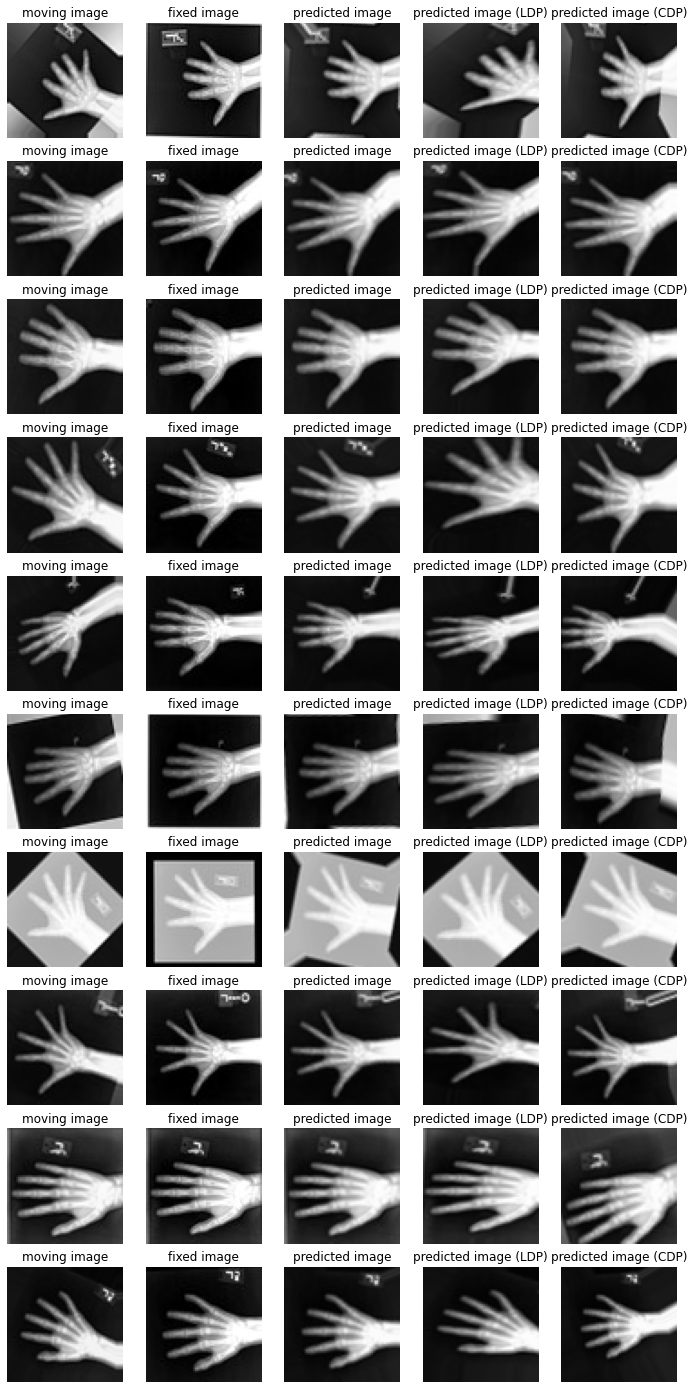

In [35]:
%matplotlib inline
batch_size = 10
plt.subplots(batch_size, 5, figsize=(12, 25))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 5, b * 5 + 1)
    plt.axis('off')
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 5, b * 5 + 2)
    plt.axis('off')
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 5, b * 5 + 3)
    plt.axis('off')
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
    # warped moving LDP
    plt.subplot(batch_size, 5, b * 5 + 4)
    plt.axis('off')
    plt.title("predicted image (LDP)")
    plt.imshow(pred_image_LDP[b], cmap="gray")
    # warped moving CDP
    plt.subplot(batch_size, 5, b * 5 + 5)
    plt.axis('off')
    plt.title("predicted image (CDP)")
    plt.imshow(pred_image_CDP[b], cmap="gray")
plt.axis('off')
plt.show()